In [2]:
include("includes.jl");

### Setup

In [50]:
@everywhere measurements, measurements_mask = load_experiments()
@everywhere kid_id = 1 # 1 3 19 20 26 28
@everywhere n_measurements = length(measurements[kid_id, measurements_mask[kid_id,:] .!= 0])

@everywhere prior = Normal(10,1)

@everywhere Θ₀ = [5*pi/180, 0]
@everywhere function dΘ(g)
    Θ -> [Θ[2], -g*sin(Θ[1])/8]
end

@everywhere grid = [0; measurements[kid_id,:][measurements_mask[kid_id,:] .!= 0]]

@everywhere loglikelihood = (n, g) ->
    let
        if n == 0
            return 0
        end
            
        c = .01
        Gg = rk4s(dΘ(g[1]), Θ₀, grid[1:n+1], 0.01) 
        
        b = log.(abs.(c ./ (c + Gg[2:end,1]))).^2
        
        (sum(b)/0.5, b[end]/2)
    end

@everywhere loglikelihood2 = (n, g) ->
    let
        if n == 0
            return 0
        end
        Gg = rk4s(dΘ(g[1]), Θ₀, grid[1:n+1], 0.01) 
        b = Gg[2:end,1].^2
        (sum(b)/0.0001, b[end]/2)
    end

full_loglikelihood = g -> loglikelihood(n_measurements, g[1])[1];
full_loglikelihood2 = g -> loglikelihood2(n_measurements, g[1])[1];

### Metropolis Hastings with gaussian noise

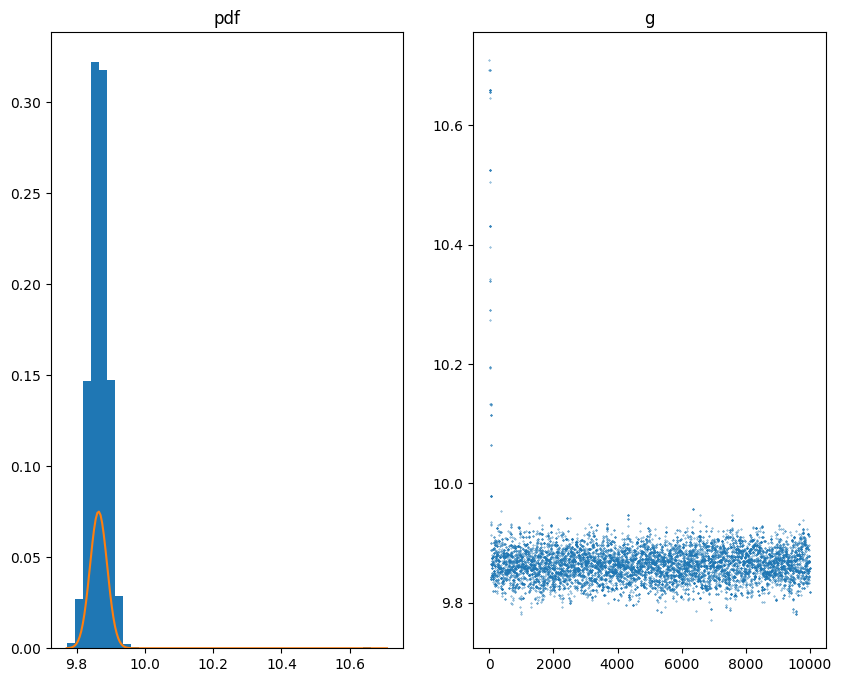

5054 / 10000 of the sampled particles were accepted (51.0%)
        
The expectation estimation is of 9.867062060758654


In [102]:
function GaussianMetropolisHastings(K, prior, ϕ, γ)
    x₀ = rand(prior, 1)
    
    X = zeros(K, length(x₀))
    Y = zeros(K, length(x₀))
    W = zeros(K)
    accepted = 0
    
    w = MvNormal(γ^2*eye(length(x₀)))
    x = x₀
    ϕₓ = ϕ(x)
    
    for k=1:K
        y = x + rand(w)
        ϕₙ = ϕ(y)
        if rand() < min(1, (pdf(prior, y[1])/pdf(prior, x[1]))*exp(ϕₓ-ϕₙ))
            x = y
            ϕₓ = ϕₙ
            accepted += 1
        end
        
        W[k] = ϕₙ
        Y[k,:] = y
        X[k,:] = x
    end
    X, Y, exp.(-W), accepted
end

out = GaussianMetropolisHastings(10_000, prior, full_loglikelihood2, 0.05)
plotMCMC(out, full_loglikelihood2)

### Sequential Monte Carlo with gaussian noise

In [23]:
function GaussianSequentialMonteCarlo(X₀, p, prior, ll; μ=0.1, n_repeat=1)
    # initialization
    N,d = size(X₀)
    w = MvNormal(μ^2 * eye(d))

    X = SharedArray{Float64}(X₀)
    dX = SharedArray{Float64,2}(X₀)
    
    alphas = SharedArray{Float64}(N)
    W = SharedArray{Float64}(N)
    
    acceptance_rate = ones(p) ./ N
    ess = zeros(p)
    maxweights = zeros(p)
    minweights = zeros(p)
    
    # initialize
    s = @parallel (+) for i=1:N
        W[i] = exp(-ll(1, X[i,:])[1])
    end
    @sync @parallel for i=1:N
        W[i] /= s
    end
    
    for n = 1:p
        # update
        copy!(dX, rand(w, N)')
        rand!(alphas)
        
        @sync @parallel for i=1:N
            W[i] = log(W[i])
        end
        
        acceptance_rate[n] *= @parallel (+) for i=1:N
            accepted = 0
            
            xₙ₋₁ = X[i,:]
            xₙ = xₙ₋₁ + dX[i,:]

            wₙ,dwₙ= ll(n, xₙ)
            wₙ₋₁,dwₙ₋₁ = ll(n, xₙ₋₁)
            
            if alphas[i] < min(1, exp(-wₙ + wₙ₋₁))
                X[i,:] = xₙ
                accepted += 1
            end
            W[i] = -dwₙ₋₁
            
            accepted
        end

        # normalize weights
        s = @parallel (+) for i=1:N
            W[i] = exp(W[i])
        end
        
        @sync @parallel for i=1:N
            W[i] /= s
        end
        
        minweights[n] = minimum(W)
        maxweights[n] = maximum(W)
        
        # resample
        ess[n] = 1 / vecdot(W,W)
        if ess[n] < N/2            
            perm = rand(Categorical(W[:]), N)
            @sync @parallel for i=1:N
                X[i,:] = X[perm[i], :]
                W[i] = 1/N
            end 
        end
        
        subplot(p/n_repeat,n_repeat,n)
        PyPlot.plt[:hist](X, 40, weights=W)
        mesh = linspace(max(9.5,minimum(X)), min(11, maximum(X)), 200)
        posterior = exp.((g -> -ll(n,g)[1] + Distributions.logpdf(prior, g)).(mesh))
        posterior /= sum(posterior)
        plot(mesh, posterior)
    end
    
    W,X,acceptance_rate,ess,minweights,maxweights
end

GaussianSequentialMonteCarlo (generic function with 1 method)

In [47]:
N = 5_000
X₀ = reshape(rand(prior, N), N, 1)

repeat = 10
modulo_llhood = (n, g) -> loglikelihood(div(n - (n-1)%repeat, repeat)+1, g)
modulo_llhood2 = (n, g) -> loglikelihood2(div(n - (n-1)%repeat, repeat)+1, g)

(::#482) (generic function with 1 method)

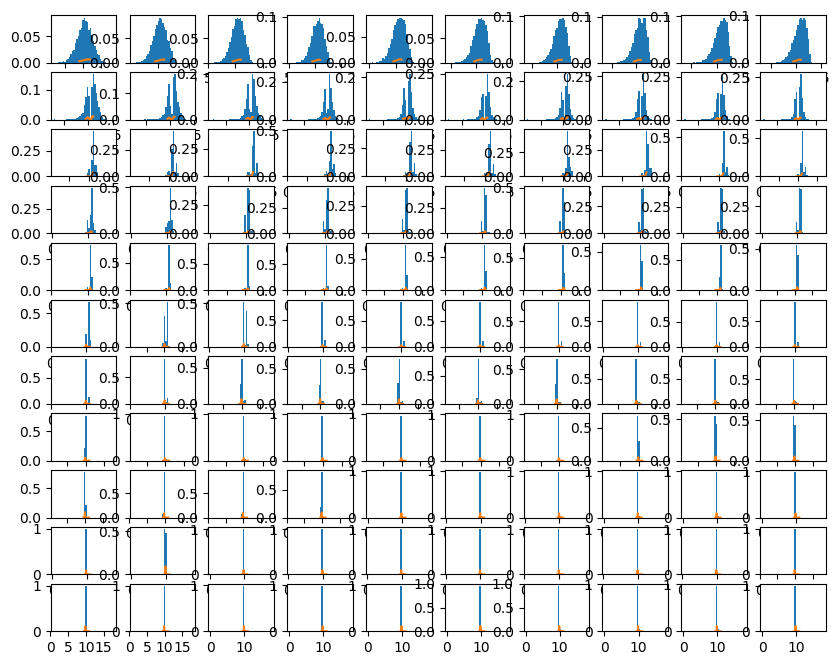

In [51]:
outs2 = GaussianSequentialMonteCarlo(X₀, repeat*n_measurements, prior, modulo_llhood, μ=0.5, n_repeat=repeat);

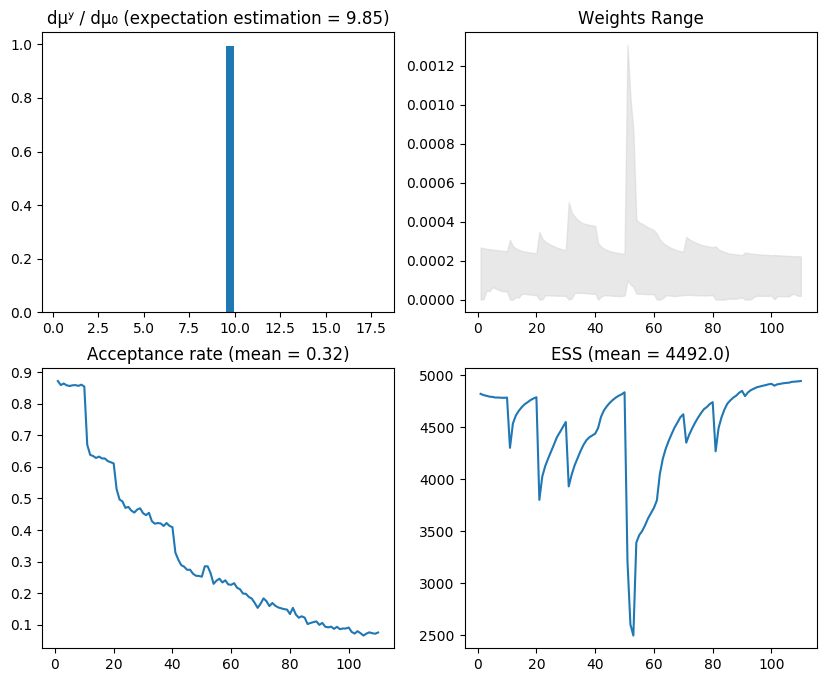

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa784c0bc50>

In [52]:
plotSMC(outs2)

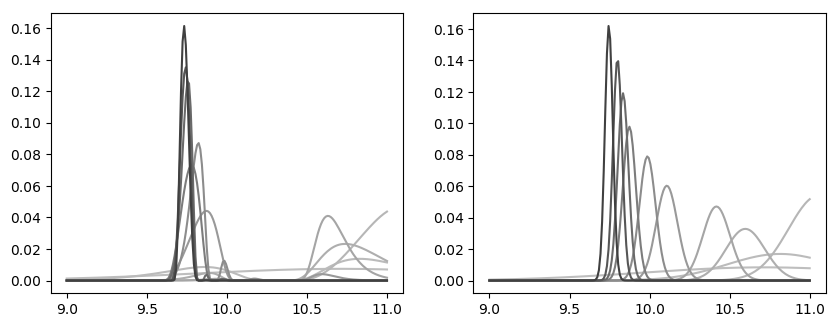

In [42]:
mesh = linspace(9,11,200)
for n=1:n_measurements
    lhood = (g -> -loglikelihood(n, g)[1] + Distributions.logpdf(prior, g)).(mesh)
    elhood = exp.(lhood)
    elhood = elhood / sum(elhood)
    
    lhood2 = (g -> -loglikelihood2(n, g)[1] + Distributions.logpdf(prior, g)).(mesh)
    elhood2 = exp.(lhood2)
    elhood2 = elhood2 / sum(elhood2)

    c = 0.75 - (n * 1.0 / n_measurements)^2/2
    
    subplot(2,2,1)
    plot(mesh, elhood, color=[c,c,c])    
    subplot(2,2,2)
    plot(mesh, elhood2, color=[c,c,c])
end

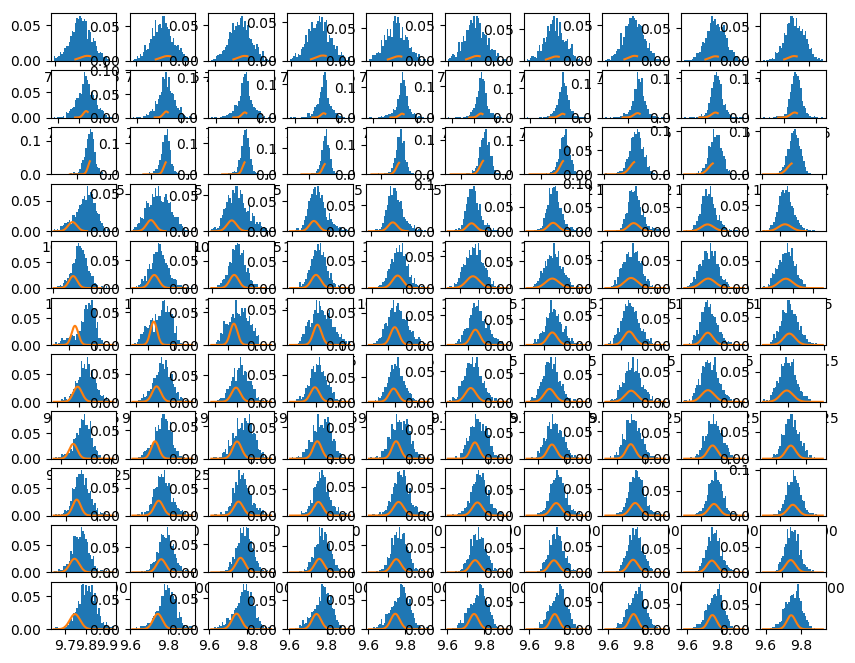

([0.00100019, 0.00100017, 0.000999231, 0.000999935, 0.00100016, 0.000999566, 0.000999911, 0.00100034, 0.00100026, 0.00100013  …  0.00100027, 0.000999795, 0.00100033, 0.00100035, 0.00100028, 0.000999821, 0.00100037, 0.000999696, 0.000999932, 0.00100019], [9.76164; 9.74286; … ; 9.74066; 9.7402], [0.79, 0.807, 0.806, 0.825, 0.834, 0.828, 0.828, 0.843, 0.831, 0.852  …  0.108, 0.124, 0.127, 0.109, 0.117, 0.092, 0.082, 0.104, 0.09, 0.072], [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0  …  1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0], [0.000999271, 0.000999354, 0.000999267, 0.000999263, 0.000999356, 0.000999353, 0.000999382, 0.000999286, 0.00099928, 0.00099915  …  0.000998106, 0.000998719, 0.000998666, 0.0009986, 0.000998559, 0.000998513, 0.000998484, 0.000998458, 0.00099844, 0.000998423], [0.00100015, 0.00100014, 0.00100013, 0.00100013, 0.00100012, 0.00100011, 0.0010001, 0.0010001, 0.00100009, 0.00100008  …  0.00100103, 0.0

In [43]:
outs = GaussianSequentialMonteCarlo(X₀, repeat*n_measurements, prior, modulo_llhood2, μ=0.5, n_repeat=repeat);

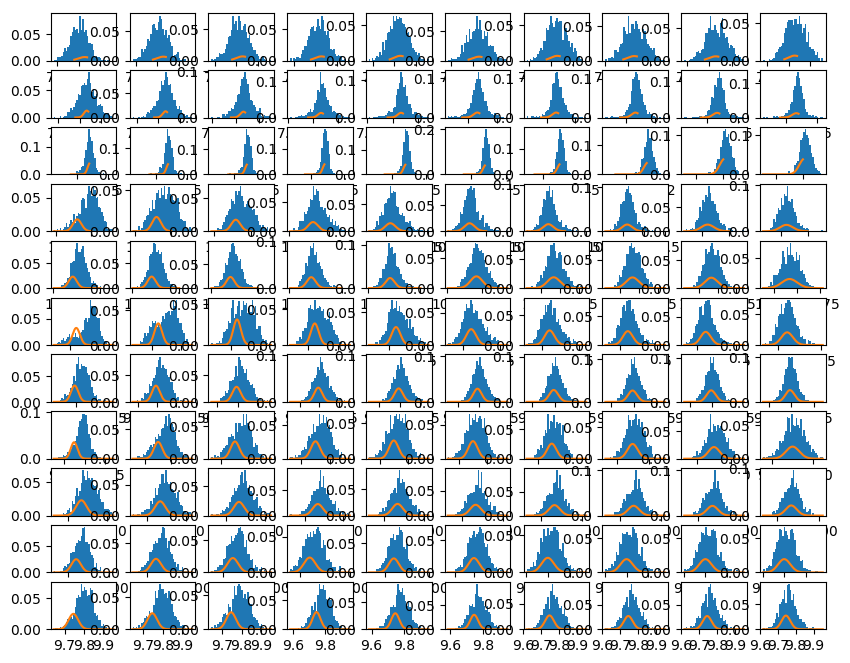

([0.00100051, 0.000999445, 0.000999905, 0.000999979, 0.0010004, 0.00100001, 0.000999377, 0.000999883, 0.00100024, 0.000999735  …  0.00100042, 0.00100028, 0.00100031, 0.000999908, 0.000999319, 0.00100061, 0.0010004, 0.00100006, 0.00100028, 0.00100037], [9.73558; 9.83157; … ; 9.72695; 9.7106], [0.808, 0.838, 0.808, 0.838, 0.833, 0.847, 0.835, 0.859, 0.829, 0.864  …  0.11, 0.128, 0.103, 0.107, 0.101, 0.093, 0.098, 0.093, 0.087, 0.094], [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0  …  1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0], [0.000999271, 0.000999262, 0.000999262, 0.000999236, 0.000999226, 0.000999218, 0.000999212, 0.00099925, 0.000999372, 0.000999243  …  0.000998187, 0.000998432, 0.000998386, 0.000998332, 0.000998277, 0.000998242, 0.000998201, 0.000998168, 0.000998148, 0.000998124], [0.00100015, 0.00100014, 0.00100013, 0.00100012, 0.00100011, 0.0010001, 0.0010001, 0.00100009, 0.00100008, 0.00100008  …  0.0010008, 0

In [29]:
outs = GaussianSequentialMonteCarlo(X₀, repeat*n_measurements, prior, modulo_llhood2, μ=0.5, n_repeat=repeat);

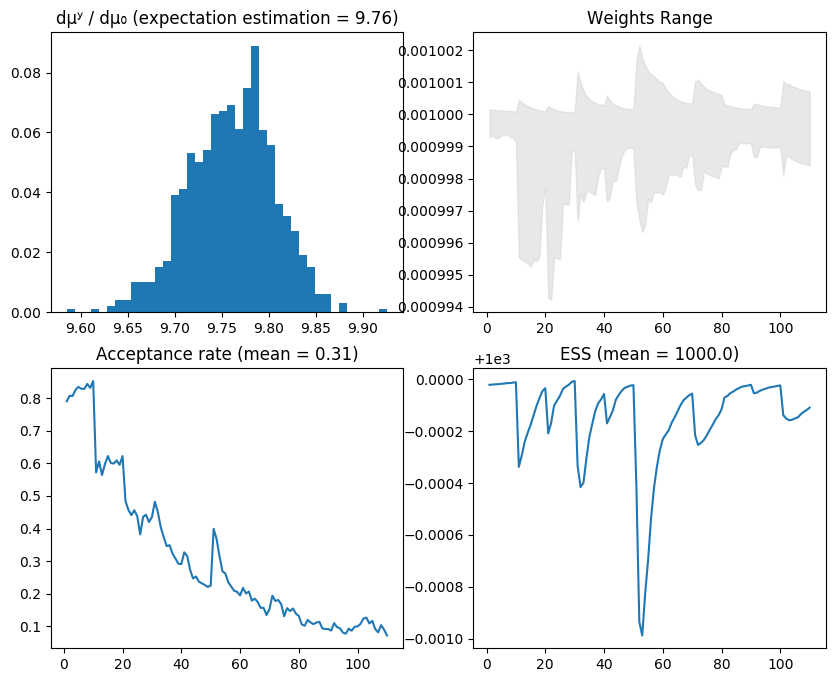

In [45]:
plotSMC(outs);